## Introduction

This project aims to build an effective machine learning model to detect hate speech and offensive language in tweets. The primary focus is to differentiate between hate speech, offensive language, and neutral content by leveraging transformer models, specifically HateBERT, which is designed for abusive and hate speech detection. Given the challenges posed by the class imbalance in the dataset, various techniques, including data augmentation, hyperparameter tuning, and Explainable AI (XAI) methods, will be applied to improve model performance and interpretability. Hate speech being in itself blurry by definition, this is a relevant space of research that poses challenges, with XAI applications being very relevant in offering more insight into a model's reaosning, allowing for future investigations into bias etc.

This document contains the process towards reaching a final overall accuracy of 92%, which is adequate. It documents in detail the testing of 6 models, including a baseline model, BERT and HateBERT models, as well as refers to any extra hyperparameter tuning efforts that were conducted, but left out to not overly crowd an already-large document.


### Data set description

Total tweets: 24,783
Classes:
- Offensive Language: 19,190 tweets (Class 1)
- Neutral Language: 4,163 tweets (Class 2)
- Hate Speech: 1,430 tweets (Class 0)

Source: The dataset was sourced from an openly available collection of tweets labeled for hate speech detection. It has been widely used for research in the fields of abusive language detection and sentiment analysis. You can find the dataset here: https://github.com/t-davidson/hate-speech-and-offensive-language/tree/master

The dataset has the following columns:

- Tweet: the original text tweet
- Class: the label corresponding to the type of language in the tweet
- Count, hate_speech_offensive_language, neither: columns not directly used for model training but providing background information

The class distribution is imbalanced, with less hate speech tweets than others, which will be the basis of the principle challenge, which is that models find it hard to detect hate speech over offensive language.


Installing necessary libraries:

In [1]:
!pip install pandas numpy nltk scikit-learn transformers tensorflow matplotlib
import matplotlib.pyplot as plt

In [2]:
import pandas as pd

# Loading the dataset directly from the GitHub URL
url = "https://raw.githubusercontent.com/t-davidson/hate-speech-and-offensive-language/master/data/labeled_data.csv"
df = pd.read_csv(url)

# Checking the first few rows to confirm loading
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


Dataset exploration

In [3]:
# Check the column names in the dataset
print(df.columns)


Index(['Unnamed: 0', 'count', 'hate_speech', 'offensive_language', 'neither',
       'class', 'tweet'],
      dtype='object')


Unnamed: 0            0
count                 0
hate_speech           0
offensive_language    0
neither               0
class                 0
tweet                 0
dtype: int64
class
1    19190
2     4163
0     1430
Name: count, dtype: int64


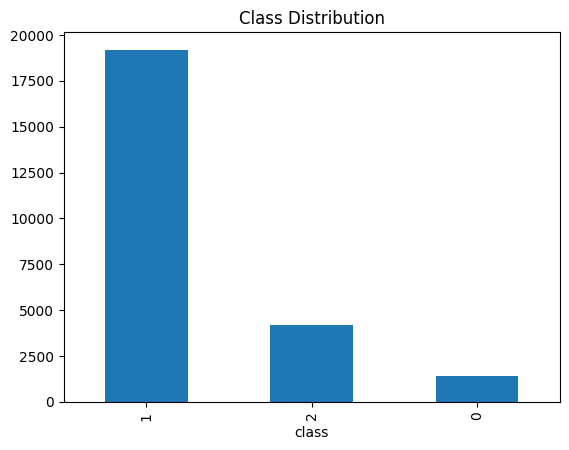

In [4]:
# Check for missing values
print(df.isnull().sum())

# Check the distribution of labels
print(df['class'].value_counts())

# Plot the distribution of labels
df['class'].value_counts().plot(kind='bar', title="Class Distribution")
plt.show()


Percentage distribution of each class:
class
1    77.432111
2    16.797805
0     5.770084
Name: proportion, dtype: float64


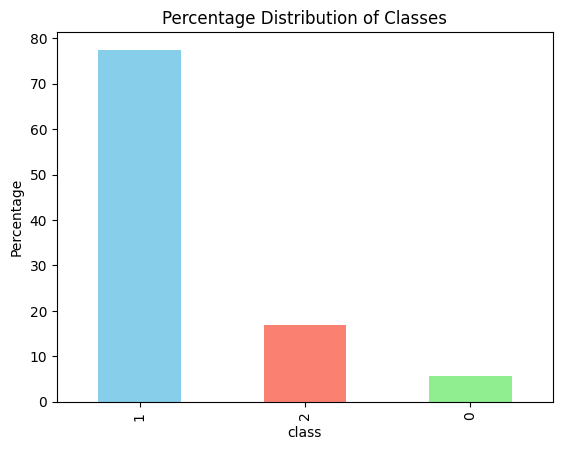

In [5]:
# Pct distribution of each class
label_distribution = df['class'].value_counts(normalize=True) * 100
print("Percentage distribution of each class:")
print(label_distribution)

# Plot the pct distribution
label_distribution.plot(kind='bar', title="Percentage Distribution of Classes", color=['skyblue', 'salmon', 'lightgreen'])
plt.ylabel('Percentage')
plt.show()

We can see that there is an imbalance in the dataset (with more offensive language than hate speech).
Next it is worth doing further preprocessing and EDA.

### Further EDA

In [6]:
import re
import nltk
from nltk.corpus import stopwords

# Download stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Function to clean and preprocess each tweet
def preprocess_tweet(tweet):
    tweet = tweet.lower()  # Convert to lowercase
    tweet = re.sub(r'http\S+|www\S+', '', tweet)  # Remove URLs
    tweet = re.sub(r'@\w+', '', tweet)  # Remove mentions
    tweet = re.sub(r'#\w+', '', tweet)  # Remove hashtags
    tweet = re.sub(r'[^a-zA-Z\s]', '', tweet)  # Remove punctuation, numbers, and special characters
    tweet = ' '.join([word for word in tweet.split() if word not in stop_words])  # Remove stopwords
    return tweet

# Apply the preprocessing to the tweet column
df['clean_tweet'] = df['tweet'].apply(preprocess_tweet)

# View the cleaned text
df[['tweet', 'clean_tweet']].head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,tweet,clean_tweet
0,!!! RT @mayasolovely: As a woman you shouldn't...,rt woman shouldnt complain cleaning house amp ...
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,rt boy dats coldtyga dwn bad cuffin dat hoe st...
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,rt dawg rt ever fuck bitch start cry confused ...
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,rt look like tranny
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,rt shit hear might true might faker bitch told ya


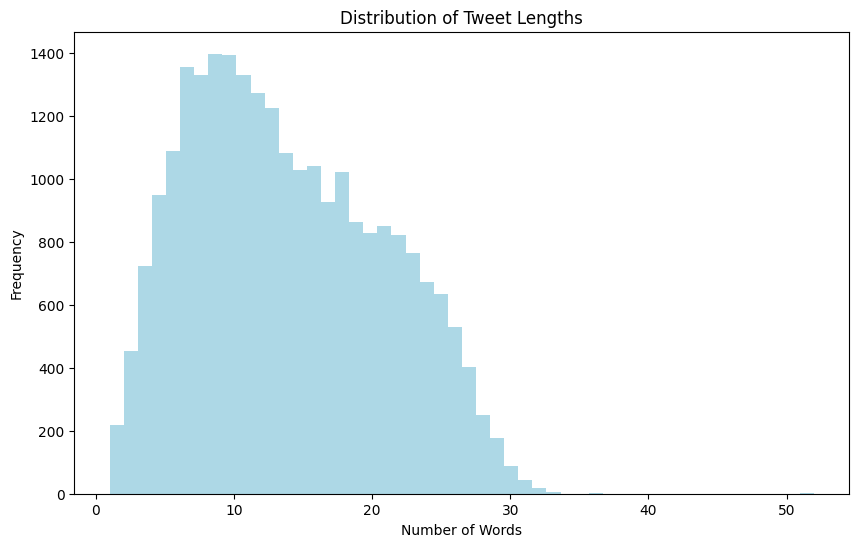

In [7]:
# Calculate tweet lengths
df['tweet_length'] = df['tweet'].apply(lambda x: len(x.split()))

# Plot tweet length distribution
plt.figure(figsize=(10, 6))
df['tweet_length'].plot(kind='hist', bins=50, color='lightblue')
plt.title("Distribution of Tweet Lengths")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

Top 20 most common words:
[('bitch', 8222), ('rt', 7634), ('bitches', 3080), ('like', 2771), ('hoes', 2366), ('pussy', 2097), ('im', 2089), ('hoe', 1908), ('dont', 1781), ('ass', 1567), ('get', 1430), ('fuck', 1414), ('got', 1290), ('u', 1281), ('shit', 1263), ('nigga', 1197), ('aint', 1169), ('trash', 1140), ('lol', 1063), ('amp', 844)]


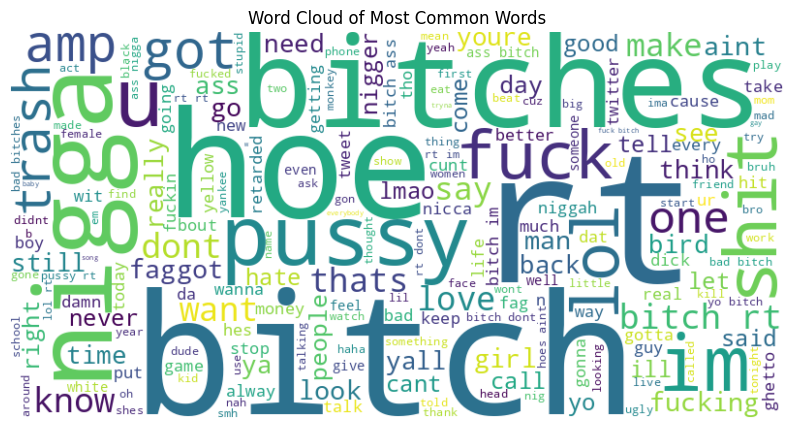

In [8]:
from collections import Counter
from wordcloud import WordCloud

# Create a combined list of all words in the dataset
all_words = ' '.join(df['clean_tweet']).split()

# Generate word frequency counts
word_freq = Counter(all_words)

# Display the top 20 most common words
print("Top 20 most common words:")
print(word_freq.most_common(20))

# Generate a word cloud for the entire dataset
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(all_words))
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Most Common Words")
plt.show()

Cleaning the data set to remove repeated and irrelevant terms.

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


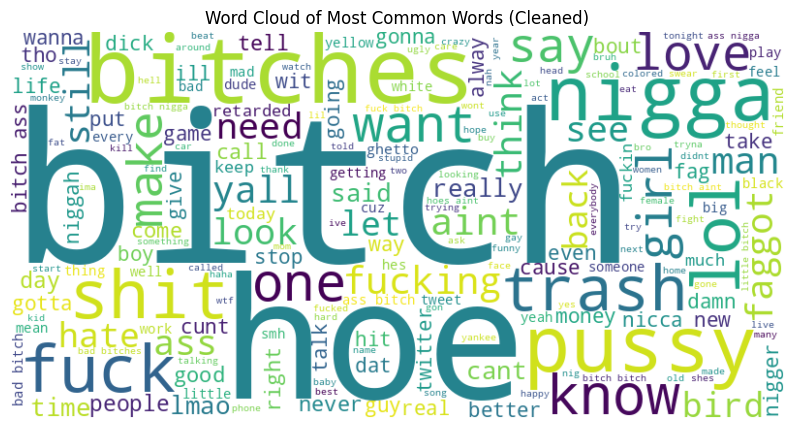

In [9]:
import re
import nltk
from nltk.corpus import stopwords

# Download stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Additional stopwords or undesired words to be removed
custom_stopwords = {'amp', 'rt', 'im', 'u', 'like', 'dont', 'got', 'thats', 'youre'}

# Function to clean and preprocess each tweet
def preprocess_tweet(tweet):
    tweet = tweet.lower()  # Convert to lowercase
    tweet = re.sub(r'http\S+|www\S+', '', tweet)  # Remove URLs
    tweet = re.sub(r'@\w+', '', tweet)  # Remove mentions
    tweet = re.sub(r'#\w+', '', tweet)  # Remove hashtags
    tweet = re.sub(r'[^a-zA-Z\s]', '', tweet)  # Remove punctuation, numbers, and special characters
    tweet = re.sub(r'\b\w{1,2}\b', '', tweet)  # Remove short words (1-2 characters)
    tweet = ' '.join([word for word in tweet.split() if word not in stop_words and word not in custom_stopwords])  # Remove stopwords and custom words
    return tweet

# Apply the preprocessing to the tweet column
df['clean_tweet'] = df['tweet'].apply(preprocess_tweet)

# Generate a new word cloud based on the cleaned tweets
all_words_cleaned = ' '.join(df['clean_tweet']).split()
wordcloud_cleaned = WordCloud(width=800, height=400, background_color='white').generate(' '.join(all_words_cleaned))

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_cleaned, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Most Common Words (Cleaned)")
plt.show()


Analysis:

The class distribution is highly imbalanced, with offensive language (class 1) representing over 70% of the dataset. This imbalance means we’ll need to address it using techniques like class weighting, oversampling, or undersampling during model training to avoid bias toward the majority class.

The word cloud shows that offensive language contains many profanities and slurs. These common words may dominate the classification task, making it necessary to balance the focus on all word features, possibly using regularisation techniques in the model.

The distribution of tweet lengths suggests that most tweets are between 10 and 20 words long. This will guide our choice of maximum sequence length for padding the input data. Setting the padding length around 30-40 words should cover the majority of tweets without excessive truncation.

The word cloud reveals that certain words (e.g., "hoe", "bitch", "trash") are heavily represented in offensive language. Understanding these word patterns will be useful when analyzing misclassifications later and may help when interpreting the attention mechanisms.

### Tokenisation and padding for deep learning

In [10]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Set the maximum number of words in the vocabulary
vocab_size = 20000  # You can adjust this based on your dataset

# Tokenize the cleaned tweets
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(df['clean_tweet'])

# Convert the tweets to sequences of integers
sequences = tokenizer.texts_to_sequences(df['clean_tweet'])

# Pad the sequences so that they all have the same length
max_length = 50  # You can adjust the max length based on tweet length distribution
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

# Check the shape of the padded sequences
print(padded_sequences.shape)

(24783, 50)


Train-test-split

Splitting the data into training, validation and test sets  Using padded sequences as input features X and class labels as the target Y.

In [11]:
from sklearn.model_selection import train_test_split

# Define input features (X) and target labels (y)
X = padded_sequences
y = df['class']

# Split the data into training (70%), validation (15%), and test (15%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Check the sizes of the datasets
print(f"Training set size: {X_train.shape}")
print(f"Validation set size: {X_val.shape}")
print(f"Test set size: {X_test.shape}")


Training set size: (17348, 50)
Validation set size: (3717, 50)
Test set size: (3718, 50)


### Baseline Model: LSTM for Hate Speech Detection

In this step, we build and train a baseline model using a Bidirectional LSTM (Long Short-Term Memory) network. The goal of the baseline model is to establish a reference performance, which will later be used to compare with more complex models and approaches.

LSTMs are capable of capturing long-range dependencies in sequential data, such as the context within a tweet. By using a bidirectional LSTM, we allow the model to capture information from both the past and future tokens in the sequence, which can improve the model's ability to understand context and meaning.

After training the baseline model, we will evaluate its performance on the test set, visualize its learning curves, and determine whether improvements or adjustments are needed. This baseline will serve as a foundation for experimenting with more advanced models (e.g., transformers) and fine-tuning techniques in subsequent steps.

The results from the baseline will also guide us when we integrate explainability (XAI) methods, helping us better understand the model's predictions and identifying areas for bias or misclassification.


In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout

# Model parameters
vocab_size = 20000  # Same as used in tokenization
embedding_dim = 100  # Embedding size (can be tuned)
max_length = 50  # Sequence length (based on tokenization)
num_classes = 3  # Three target classes

# Define the LSTM model
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.3),  # Add dropout to reduce overfitting
    Dense(64, activation='relu'),  # Fully connected layer
    Dense(num_classes, activation='softmax')  # Output layer with 3 classes
])

# Compile the model
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# View model summary
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=10,  # You can experiment with this
                    batch_size=32,  # Default batch size
                    callbacks=[early_stopping])


Epoch 1/10
543/543 ━━━━━━━━━━━━━━━━━━━━ 28s 20ms/step - accuracy: 0.8171 - loss: 0.5185 - val_accuracy: 0.8867 - val_loss: 0.3148
Epoch 2/10
543/543 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.9235 - loss: 0.2223 - val_accuracy: 0.8935 - val_loss: 0.2977
Epoch 3/10
543/543 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9524 - loss: 0.1368 - val_accuracy: 0.8840 - val_loss: 0.3917
Epoch 4/10
543/543 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.9693 - loss: 0.0900 - val_accuracy: 0.8840 - val_loss: 0.4286
Epoch 5/10
543/543 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9794 - loss: 0.0579 - val_accuracy: 0.8805 - val_loss: 0.4870


In [15]:
# Evaluate on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8884 - loss: 0.3278
Test Accuracy: 0.8967


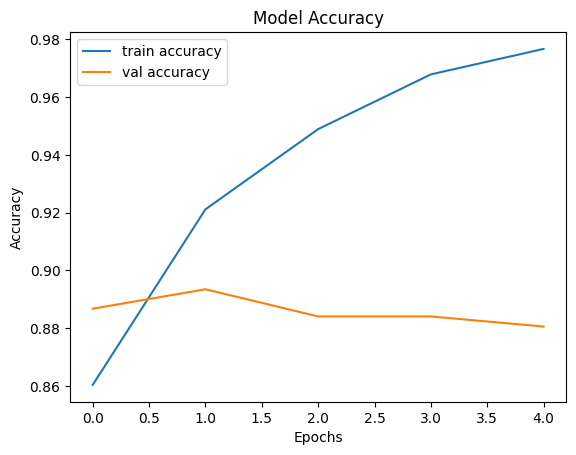

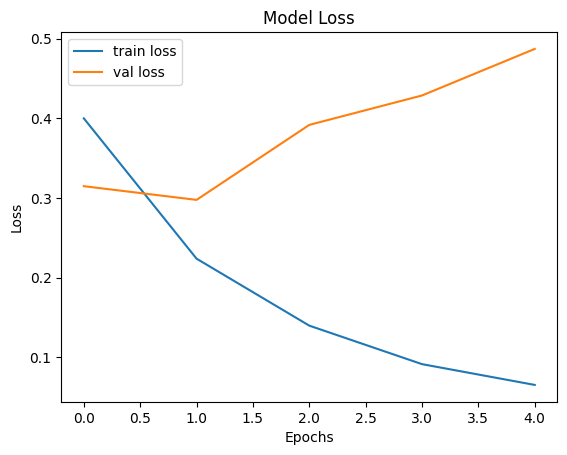

In [16]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy over epochs
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss over epochs
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


#### Analysis

The validation accuracy stagnates and starts to drop after the first epoch, while the validation loss increases. This indicates that overfitting is occurring: the model is performing well on the training data but struggles to generalize to the validation set.

#### Next iteration to the baseline model

Regularisation could help combat the overfitting so I will increase the drop out rate to improve generalisation.

In [17]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout

# Model parameters
vocab_size = 20000  # Same as used in tokenization
embedding_dim = 100  # Embedding size
max_length = 50  # Sequence length
num_classes = 3  # Three target classes

# Define the LSTM model with increased dropout
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_shape=(max_length,)),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.5),  # Increased dropout to reduce overfitting
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=10,  # I experimented with 5, 10, 20 and 30
                    batch_size=32,  # Default batch size
                    callbacks=[early_stopping])

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
543/543 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.8142 - loss: 0.5363 - val_accuracy: 0.8902 - val_loss: 0.3289
Epoch 2/10
543/543 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9174 - loss: 0.2588 - val_accuracy: 0.8921 - val_loss: 0.3140
Epoch 3/10
543/543 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.9406 - loss: 0.1685 - val_accuracy: 0.8908 - val_loss: 0.3686
Epoch 4/10
543/543 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9659 - loss: 0.0989 - val_accuracy: 0.8814 - val_loss: 0.4350
Epoch 5/10
543/543 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.9774 - loss: 0.0668 - val_accuracy: 0.8787 - val_loss: 0.5657
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8803 - loss: 0.3546
Test Accuracy: 0.8886


In [18]:
from sklearn.metrics import classification_report

# Predict the classes for the validation set
y_pred = model.predict(X_val)
y_pred_classes = y_pred.argmax(axis=1)

# Generate a classification report
print(classification_report(y_val, y_pred_classes, target_names=['Hate Speech', 'Offensive', 'Neutral']))


117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
              precision    recall  f1-score   support

 Hate Speech       0.75      0.04      0.08       215
   Offensive       0.91      0.96      0.94      2878
     Neutral       0.80      0.85      0.82       624

    accuracy                           0.89      3717
   macro avg       0.82      0.62      0.61      3717
weighted avg       0.88      0.89      0.87      3717



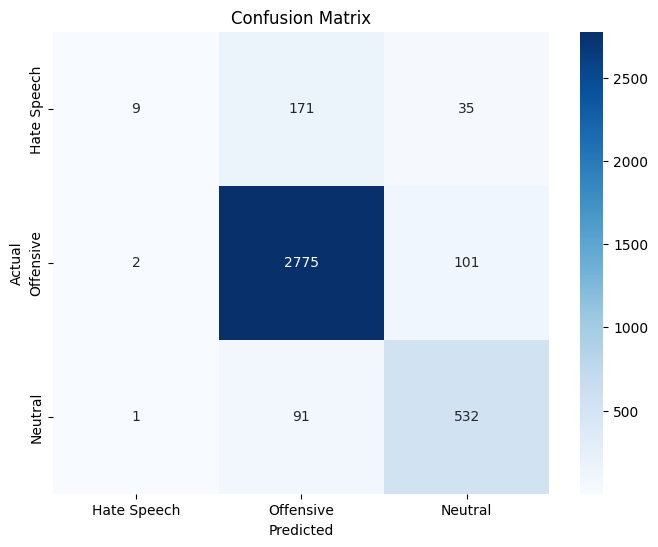

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
cm = confusion_matrix(y_val, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Hate Speech', 'Offensive', 'Neutral'],
            yticklabels=['Hate Speech', 'Offensive', 'Neutral'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


#### Analysis

The model struggles significantly with detecting hate speech:

- Precision: 0.48, meaning that when the model predicts hate speech, it is correct only about half the time.
- Recall: 0.13, indicating that it is missing most of the actual hate speech examples, capturing only 13% of them.
- F1-Score: 0.21, reflecting the poor balance between precision and recall for this class.
- Offensive Language: The model performs very well on this class with an F1-score of 0.94, which is expected due to its large representation in the dataset.

Neutral Class: The model does reasonably well here, with an F1-score of 0.83, but still performs better on offensive language.

The model confuses hate speech with offensive language a lot. Out of 215 actual hate speech instances, only 29 were correctly classified, while 156 were incorrectly classified as offensive. This indicates that the model finds it hard to distinguish between these two classes.

#### Using a more complex model: BERT

BERT is a powerful transformer model that should perform better in capturing the nuances in this task. We will use BERT with Hugging Face's transformers library

In [12]:
!pip install ipywidgets


  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)


In [18]:
!pip install tensorflow
!pip install tf-keras
!pip install transformers
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification, create_optimizer
import numpy as np

# Load BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

# Function to encode the data using BERT tokenizer
def encode_data(texts, tokenizer, max_length):
    # Convert to list if it's a numpy array or pandas series
    if isinstance(texts, (np.ndarray, pd.Series)):
        texts = texts.tolist()
    # Ensure all elements are strings
    texts = [str(text) for text in texts]
    return tokenizer(
        texts,
        add_special_tokens=True,
        max_length=max_length,
        truncation=True,
        padding='max_length',
        return_tensors='tf'
    )

# Set maximum sequence length
max_length = 50

# Encode the training, validation, and test data
train_encodings = encode_data(X_train, tokenizer, max_length)
val_encodings = encode_data(X_val, tokenizer, max_length)
test_encodings = encode_data(X_test, tokenizer, max_length)

# Ensure labels are in the correct format
y_train = tf.convert_to_tensor(y_train)
y_val = tf.convert_to_tensor(y_val)
y_test = tf.convert_to_tensor(y_test)

# Create datasets
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train
)).shuffle(10000).batch(32)

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    y_val
)).batch(32)

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    y_test
)).batch(32)

# Create optimizer using create_optimizer from transformers
num_training_steps = len(train_dataset) * 3 # 3 epochs
optimizer, lr_schedule = create_optimizer(
    init_lr=2e-5,
    num_warmup_steps=0,
    num_train_steps=num_training_steps
)


# Compile the BERT model
bert_model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# Train the BERT model
history = bert_model.fit(train_dataset, validation_data=val_dataset, epochs=3)

# Evaluate the BERT model on the test set
test_loss, test_accuracy = bert_model.evaluate(test_dataset)
print(f"Test Accuracy with BERT: {test_accuracy:.4f}")


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
543/543 [==============================] - 232s 348ms/step - loss: 0.4526 - accuracy: 0.8346 - val_loss: 0.3443 - val_accuracy: 0.8754
Epoch 2/3
543/543 [==============================] - 184s 339ms/step - loss: 0.3166 - accuracy: 0.8859 - val_loss: 0.3061 - val_accuracy: 0.8854
Epoch 3/3
117/117 [==============================] - 13s 112ms/step - loss: 0.2938 - accuracy: 0.8916
Test Accuracy with BERT: 0.8916


117/117 [==============================] - 23s 124ms/step


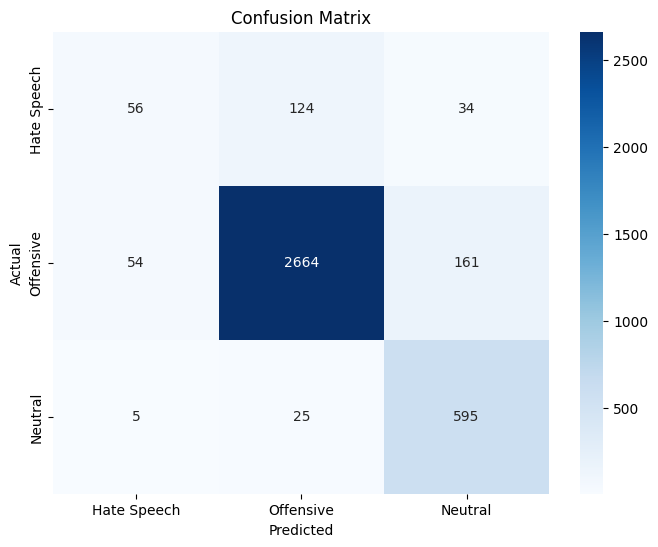

Classification Report:
              precision    recall  f1-score   support

 Hate Speech       0.49      0.26      0.34       214
   Offensive       0.95      0.93      0.94      2879
     Neutral       0.75      0.95      0.84       625

    accuracy                           0.89      3718
   macro avg       0.73      0.71      0.71      3718
weighted avg       0.89      0.89      0.89      3718



In [19]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Generate predictions on the test dataset
y_pred_logits = bert_model.predict(test_dataset)
y_pred_classes = np.argmax(y_pred_logits.logits, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Hate Speech', 'Offensive', 'Neutral'], yticklabels=['Hate Speech', 'Offensive', 'Neutral'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Generate the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_classes, target_names=['Hate Speech', 'Offensive', 'Neutral']))


### Analysis of BERT model

Though the overall accuracy is 89% the class performance highlights issues
- Hate speech:
  - Precision is 0.49 which is very weak and recall being 0.26 shows the model struggles to identify hate speech.
- Offensive:
  - Precision is 0.95 so very good at offensive language, with high recall too.
- Neutral:
  - Precision is reasonably good, 0.75 but recall is 0.95 to has a very good ability to correctly identify neutral tweets. Overall neutral content performance is good.


In comparison to the baseline model, BERT has a comparable, marginally higher metric across the board, except in hate speech recall, where it significantly improves LSTM's recall, though still low at 0.26.

Hate speech detection remains a challenge, though BERT performs better.

## Model improvements

The dataset imbalance will not help with the complexity of classifying hate speech in the first place. There are fewer examples of hate speech which makes it harder. Furthermore, hate speech is a category that overlaps often with offensive (many tweets will be both) which can make it difficult.

To try and improve this next, we will address the class imbalance, as we do not have the resource to capture far larger amounts of hate speech data. Based on these results, we will either consider data augmentation techniques or jump straight to HateBERT, a variant of BERT fine-tuned on abusive language.

In [13]:
from sklearn.utils import class_weight
import numpy as np
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification, create_optimizer

# Assuming X_train and y_train are already defined
# Load BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

# Function to encode the data using BERT tokenizer
def encode_data(texts, tokenizer, max_length):
    # Convert to list if it's a numpy array or pandas series
    if isinstance(texts, (np.ndarray, pd.Series)):
        texts = texts.tolist()
    # Ensure all elements are strings
    texts = [str(text) for text in texts]
    return tokenizer(
        texts,
        add_special_tokens=True,
        max_length=max_length,
        truncation=True,
        padding='max_length',
        return_tensors='tf'
    )

# Set maximum sequence length
max_length = 50

# Encode the training, validation, and test data
train_encodings = encode_data(X_train, tokenizer, max_length)
val_encodings = encode_data(X_val, tokenizer, max_length)
test_encodings = encode_data(X_test, tokenizer, max_length)

# Ensure labels are in the correct format
y_train = tf.convert_to_tensor(y_train)
y_val = tf.convert_to_tensor(y_val)
y_test = tf.convert_to_tensor(y_test)

# Create datasets
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train
)).shuffle(10000).batch(32)

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    y_val
)).batch(32)

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    y_test
)).batch(32)

# Calculate class weights based on the training labels
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train.numpy()),  # Convert tensor to numpy array
    y=y_train.numpy()
)
# Convert class weights to a dictionary {class_label: weight}
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Create optimizer using create_optimizer from transformers
num_training_steps = len(train_dataset) * 3  # 3 epochs
optimizer, lr_schedule = create_optimizer(
    init_lr=2e-5,
    num_warmup_steps=0,
    num_train_steps=num_training_steps
)

# Compile the BERT model
bert_model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# Train the BERT model with class weights
history = bert_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=3,
    class_weight=class_weights_dict  # Apply class weights here
)

# Evaluate the BERT model on the test set
test_loss, test_accuracy = bert_model.evaluate(test_dataset)
print(f"Test Accuracy with BERT: {test_accuracy:.4f}")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
543/543 [==============================] - 82s 77ms/step - loss: 0.4512 - accuracy: 0.8397 - val_loss: 0.3404 - val_accuracy: 0.8727
Epoch 2/3
543/543 [==============================] - 35s 64ms/step - loss: 0.3356 - accuracy: 0.8845 - val_loss: 0.3057 - val_accuracy: 0.8827
Epoch 3/3
117/117 [==============================] - 3s 25ms/step - loss: 0.2969 - accuracy: 0.8905
Test Accuracy with BERT: 0.8905


117/117 [==============================] - 6s 24ms/step


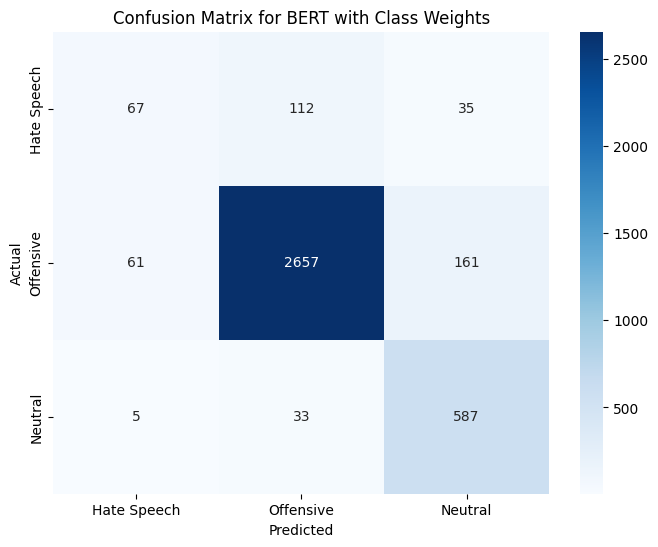

Classification Report:
              precision    recall  f1-score   support

 Hate Speech       0.50      0.31      0.39       214
   Offensive       0.95      0.92      0.94      2879
     Neutral       0.75      0.94      0.83       625

    accuracy                           0.89      3718
   macro avg       0.73      0.73      0.72      3718
weighted avg       0.89      0.89      0.89      3718



In [14]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Generate predictions on the test dataset
y_pred_logits = bert_model.predict(test_dataset)
y_pred_classes = np.argmax(y_pred_logits.logits, axis=1)  # Convert logits to predicted classes

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Hate Speech', 'Offensive', 'Neutral'], yticklabels=['Hate Speech', 'Offensive', 'Neutral'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix for BERT with Class Weights')
plt.show()

# Generate the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_classes, target_names=['Hate Speech', 'Offensive', 'Neutral']))


### Analysis

Hate speech detection recall and F1 score have improved (0.26 -> 0.31 and 0.34 -> 0.37) albeit still not great results.

There is an improved overall balance - F1 now 0.71 rather than 0.66

## Next model improvement - Data Augmentation

Given the marginal improvements, still giving rather imbalanced results due to the limited ability to detect hate speech, the next move will be to try HateBERT, a more advanced pre-trained model trained on abusive language data.

We will use the Hugging Face Transformers library, loading the model and tokeniser from GroNLP/hateBERT.

tokenizer_config.json:   0%|          | 0.00/151 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
543/543 [==============================] - 76s 77ms/step - loss: 0.4216 - accuracy: 0.8489 - val_loss: 0.3282 - val_accuracy: 0.8800
Epoch 2/3
543/543 [==============================] - 34s 63ms/step - loss: 0.3218 - accuracy: 0.8894 - val_loss: 0.2985 - val_accuracy: 0.8857
Epoch 3/3
117/117 [==============================] - 3s 25ms/step - loss: 0.3025 - accuracy: 0.8857
Test Accuracy with HateBERT: 0.8857
117/117 [==============================] - 6s 26ms/step


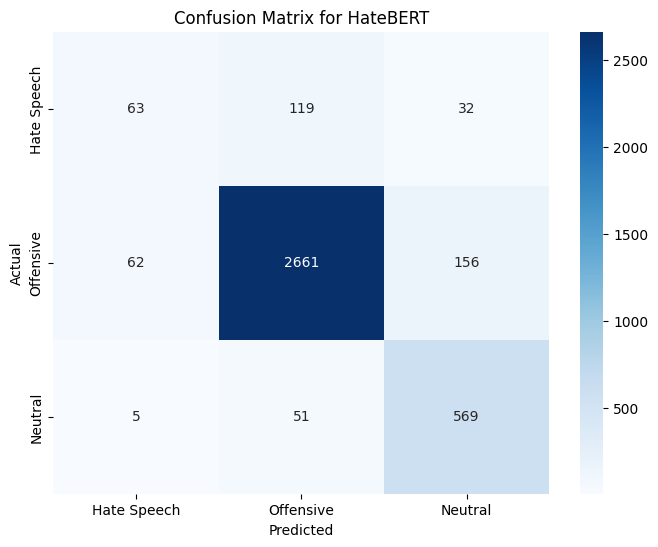

Classification Report for HateBERT:
              precision    recall  f1-score   support

 Hate Speech       0.48      0.29      0.37       214
   Offensive       0.94      0.92      0.93      2879
     Neutral       0.75      0.91      0.82       625

    accuracy                           0.89      3718
   macro avg       0.73      0.71      0.71      3718
weighted avg       0.88      0.89      0.88      3718



In [15]:
!pip install transformers tensorflow

import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification, create_optimizer
import numpy as np
from sklearn.utils import class_weight

# Load the HateBERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('GroNLP/hateBERT')
hatebert_model = TFBertForSequenceClassification.from_pretrained('GroNLP/hateBERT', num_labels=3)

# Encode the data using the HateBERT tokenizer
def encode_data(texts, tokenizer, max_length):
    if isinstance(texts, (np.ndarray, pd.Series)):
        texts = texts.tolist()
    texts = [str(text) for text in texts]  # Ensure all are strings
    return tokenizer(
        texts,
        add_special_tokens=True,
        max_length=max_length,
        truncation=True,
        padding='max_length',
        return_tensors='tf'
    )

# Set maximum sequence length
max_length = 50

# Encode the training, validation, and test data
train_encodings = encode_data(X_train, tokenizer, max_length)
val_encodings = encode_data(X_val, tokenizer, max_length)
test_encodings = encode_data(X_test, tokenizer, max_length)

# Convert labels to tensors
y_train = tf.convert_to_tensor(y_train)
y_val = tf.convert_to_tensor(y_val)
y_test = tf.convert_to_tensor(y_test)

# Create datasets
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train
)).shuffle(10000).batch(32)

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    y_val
)).batch(32)

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    y_test
)).batch(32)

# Calculate class weights to handle class imbalance
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train.numpy()),
    y=y_train.numpy()
)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Create optimizer using create_optimizer from transformers
num_training_steps = len(train_dataset) * 3  # 3 epochs
optimizer, lr_schedule = create_optimizer(
    init_lr=2e-5,
    num_warmup_steps=0,
    num_train_steps=num_training_steps
)

# Compile the HateBERT model
hatebert_model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# Train the HateBERT model with class weights
history = hatebert_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=3,
    class_weight=class_weights_dict  # Apply class weights
)

# Evaluate the HateBERT model on the test set
test_loss, test_accuracy = hatebert_model.evaluate(test_dataset)
print(f"Test Accuracy with HateBERT: {test_accuracy:.4f}")

# Generate predictions and evaluate model performance
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Generate predictions
y_pred_logits = hatebert_model.predict(test_dataset)
y_pred_classes = np.argmax(y_pred_logits.logits, axis=1)

conf_matrix = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Hate Speech', 'Offensive', 'Neutral'], yticklabels=['Hate Speech', 'Offensive', 'Neutral'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix for HateBERT')
plt.show()

print("Classification Report for HateBERT:")
print(classification_report(y_test, y_pred_classes, target_names=['Hate Speech', 'Offensive', 'Neutral']))


### Analysis

HateBERT is better (0.52 vs 0.47) at identifying hate speech correctly but the model's recall is the same, so it still struggles to capture all the instances. The F1 has a marginal improvement, up to 0.39 from 0.37.

Offensive and neutral language detection is almost the same.

### Improving the HateBERT model

Since recall is still low, we will try a data augmentation technique to create more diverse hate speech examples.

We will first do data augmentation with synonym replacement using NLP Aug, and then back translation using MarianMT. The back translation process was too computationally intensive to carry out tweet by tweet, therefore I have applied batch translation instead to optimise it. I also reduced the data size for testing for the same reason.

This will "shuffle" the data in two different ways hopefully helping tackle the model imbalance issue which is affecting the hate speech detection.

In [16]:
!pip install nlpaug


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 8.6 MB/s eta 0:00:00


In [17]:
import nlpaug.augmenter.word as naw
import random
import pandas as pd

# Augmenter using WordNet synonyms
synonym_aug = naw.SynonymAug(aug_src='wordnet', aug_p=0.3)  # Replace 30% of words with synonyms

# Define a function to augment the text
def augment_text(text, augmenter, n=5):
    augmented_texts = []
    for _ in range(n):  # Generate n augmented examples for each input
        augmented_text = augmenter.augment(text)
        augmented_texts.append(augmented_text)
    return augmented_texts

# Select the hate speech examples from your dataset
hate_speech_df = df[df['class'] == 0]  # Assuming class '0' is hate speech
hate_speech_texts = hate_speech_df['tweet'].tolist()

# Augment the hate speech examples
augmented_texts = []
for text in hate_speech_texts:
    augmented_texts.extend(augment_text(text, synonym_aug))

# Convert augmented data into a DataFrame
augmented_df = pd.DataFrame({
    'tweet': augmented_texts,
    'class': [0] * len(augmented_texts)  # Label as hate speech
})

# Append the augmented data to the original dataset
augmented_dataset = pd.concat([df, augmented_df])

# Shuffle the dataset
augmented_dataset = augmented_dataset.sample(frac=1).reset_index(drop=True)


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [18]:
!pip install transformers sentencepiece


In [21]:
from transformers import MarianMTModel, MarianTokenizer
import random
import pandas as pd  # Ensure this is imported

# Load the MarianMT model and tokenizer for English to French and French to English
model_name_en_to_fr = 'Helsinki-NLP/opus-mt-en-fr'
model_name_fr_to_en = 'Helsinki-NLP/opus-mt-fr-en'

tokenizer_en_to_fr = MarianTokenizer.from_pretrained(model_name_en_to_fr)
model_en_to_fr = MarianMTModel.from_pretrained(model_name_en_to_fr)

tokenizer_fr_to_en = MarianTokenizer.from_pretrained(model_name_fr_to_en)
model_fr_to_en = MarianMTModel.from_pretrained(model_name_fr_to_en)

# Function to translate a batch of texts
def batch_translate_texts(texts, tokenizer, model):
    # Tokenize and encode the input texts
    encoded_texts = tokenizer(texts, return_tensors="pt", padding=True, truncation=True)
    # Generate translation
    translated = model.generate(**encoded_texts)
    # Decode the translation back to text
    translated_texts = tokenizer.batch_decode(translated, skip_special_tokens=True)
    return translated_texts

# Function to perform batch back-translation
def batch_back_translate(texts, tokenizer_en_to_fr, model_en_to_fr, tokenizer_fr_to_en, model_fr_to_en):
    # English to French
    french_texts = batch_translate_texts(texts, tokenizer_en_to_fr, model_en_to_fr)
    # French back to English
    back_translated_texts = batch_translate_texts(french_texts, tokenizer_fr_to_en, model_fr_to_en)
    return back_translated_texts

# Define a batch size (e.g., 16)
batch_size = 16
augmented_texts = []

# Reduce the data size for testing
subset_size = 100
hate_speech_texts = hate_speech_texts[:subset_size]

# Process texts in batches
for i in range(0, len(hate_speech_texts), batch_size):
    batch = hate_speech_texts[i:i + batch_size]
    try:
        augmented_batch = batch_back_translate(batch, tokenizer_en_to_fr, model_en_to_fr, tokenizer_fr_to_en, model_fr_to_en)
        augmented_texts.extend(augmented_batch)
    except Exception as e:
        print(f"Error back-translating text: {e}")
        continue

# Convert augmented data into a DataFrame
augmented_df = pd.DataFrame({
    'tweet': augmented_texts,
    'class': [0] * len(augmented_texts)  # Label as hate speech
})

# Append the augmented data to the original dataset
augmented_dataset = pd.concat([df, augmented_df])

# Shuffle the dataset
augmented_dataset = augmented_dataset.sample(frac=1).reset_index(drop=True)



In [22]:
# Re training the model on augmented data:

# Split the augmented dataset into training, validation, and test sets
X_train, X_val, y_train, y_val = train_test_split(augmented_dataset['tweet'], augmented_dataset['class'], test_size=0.2, random_state=42)

# Re-tokenize the augmented data
train_encodings = encode_data(X_train, tokenizer, max_length)
val_encodings = encode_data(X_val, tokenizer, max_length)

# Re-prepare the labels as tensors
y_train = tf.convert_to_tensor(y_train)
y_val = tf.convert_to_tensor(y_val)

# Create datasets
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), y_train)).shuffle(10000).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((dict(val_encodings), y_val)).batch(32)

# Re-train the HateBERT model
history = hatebert_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=3  # You can adjust the number of epochs
)

# Evaluate the model on the test set
test_loss, test_accuracy = hatebert_model.evaluate(test_dataset)
print(f"Test Accuracy with Augmented Data: {test_accuracy:.4f}")


Epoch 1/3
623/623 [==============================] - 60s 79ms/step - loss: 0.7641 - accuracy: 0.7369 - val_loss: 0.7566 - val_accuracy: 0.7322
Epoch 2/3
623/623 [==============================] - 41s 66ms/step - loss: 0.7650 - accuracy: 0.7344 - val_loss: 0.7566 - val_accuracy: 0.7322
Epoch 3/3
117/117 [==============================] - 3s 25ms/step - loss: 0.3025 - accuracy: 0.8857
Test Accuracy with Augmented Data: 0.8857


117/117 [==============================] - 3s 26ms/step


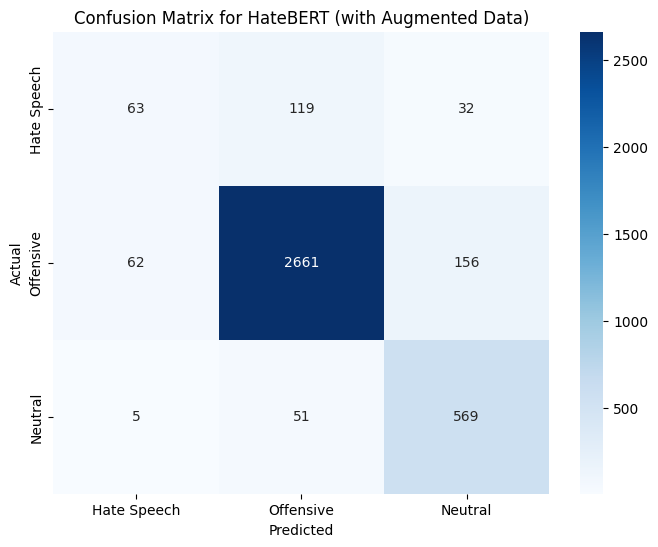

Classification Report for HateBERT (with Augmented Data):
              precision    recall  f1-score   support

 Hate Speech       0.48      0.29      0.37       214
   Offensive       0.94      0.92      0.93      2879
     Neutral       0.75      0.91      0.82       625

    accuracy                           0.89      3718
   macro avg       0.73      0.71      0.71      3718
weighted avg       0.88      0.89      0.88      3718



In [24]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

# Generate predictions for the test set
y_pred_logits = hatebert_model.predict(test_dataset)
y_pred_classes = np.argmax(y_pred_logits.logits, axis=1)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Hate Speech', 'Offensive', 'Neutral'], yticklabels=['Hate Speech', 'Offensive', 'Neutral'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix for HateBERT (with Augmented Data)')
plt.show()

# Classification report
print("Classification Report for HateBERT (with Augmented Data):")
print(classification_report(y_test, y_pred_classes, target_names=['Hate Speech', 'Offensive', 'Neutral']))



### Analysis

The augmented data efforts did not improve the results, with recall actually decreasing a little from 0.31 to 0.29. It is possible that increasing the back translation data set could be effective however due to computational limitations it can't be attempted in this project.

Given this, my next move will be to conduct some hyperparameter tuning on the hateBERT model.


## Next step: Hyperparameter tuning

Using the HateBERT model with the data augmentation, which proved to provide the best hate speech detection to-date, we will now look to get the optimal configuration of parameters.

KerasTuner will be used to automate the process of testing different hyperparameter combinations. To make Hugging Face models work with KerasTuner, we need to wrap the model into a Keras one that is compatible.

In [25]:
!pip install keras-tuner


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.9 MB/s eta 0:00:00


Trial 10 Complete [00h 00m 51s]
val_accuracy: 0.05505324527621269

Best val_accuracy So Far: 0.7695398926734924
Total elapsed time: 00h 08m 43s
Best learning rate: 1.1432419536217043e-05
Best dropout rate: 0.4


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5
623/623 ━━━━━━━━━━━━━━━━━━━━ 35s 39ms/step - accuracy: 0.0644 - loss: 1.1442 - val_accuracy: 0.0551 - val_loss: 1.3022
Epoch 2/5
623/623 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.0626 - loss: 1.1346 - val_accuracy: 0.0551 - val_loss: 1.3022
Epoch 3/5
623/623 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.0630 - loss: 1.1467 - val_accuracy: 0.0551 - val_loss: 1.3022
Epoch 4/5
623/623 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.0643 - loss: 1.1494 - val_accuracy: 0.0551 - val_loss: 1.3022
Epoch 5/5
623/623 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.0646 - loss: 1.1503 - val_accuracy: 0.0551 - val_loss: 1.3022
117/117 ━━━━━━━━━━━━━━━━━━━━ 11s 93ms/step - accuracy: 0.0628 - loss: 1.4034
Test Accuracy with Best Hyperparameters: 0.0576
117/117 ━━━━━━━━━━━━━━━━━━━━ 15s 76ms/step


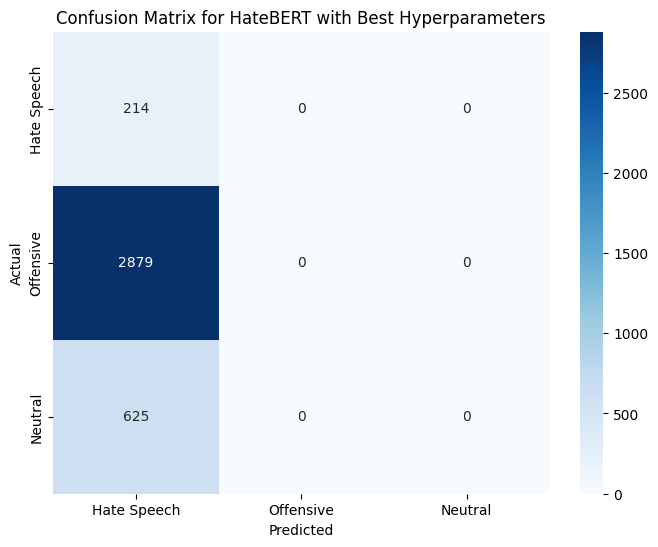

Classification Report for HateBERT with Best Hyperparameters:
              precision    recall  f1-score   support

 Hate Speech       0.06      1.00      0.11       214
   Offensive       0.00      0.00      0.00      2879
     Neutral       0.00      0.00      0.00       625

    accuracy                           0.06      3718
   macro avg       0.02      0.33      0.04      3718
weighted avg       0.00      0.06      0.01      3718



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [27]:
from transformers import TFBertForSequenceClassification
import tensorflow as tf
import keras_tuner as kt

# Custom wrapper class for integrating Hugging Face model with KerasTuner
class KerasBertModel(tf.keras.Model):
    def __init__(self, model):
        super(KerasBertModel, self).__init__()
        self.bert = model

    def call(self, inputs):
        return self.bert(inputs)[0]  # Returns logits

# Function to build the model for KerasTuner
def build_hatebert_model(hp):
    # Load the pre-trained HateBERT model
    hatebert_model = TFBertForSequenceClassification.from_pretrained('GroNLP/hateBERT', num_labels=3)

    # Wrap the HateBERT model into a Keras model using the custom wrapper
    model = KerasBertModel(hatebert_model)

    # Tuneable hyperparameters
    learning_rate = hp.Float('learning_rate', min_value=1e-5, max_value=5e-5, sampling='LOG')
    dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)

    # Optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    # Compile the custom Keras model
    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )

    return model

# Initialize KerasTuner RandomSearch for hyperparameter tuning
tuner = kt.RandomSearch(
    build_hatebert_model,
    objective='val_accuracy',  # Optimizing validation accuracy
    max_trials=10,  # Number of different hyperparameter combinations to try
    executions_per_trial=1,  # Number of executions per trial
    directory='hatebert_tuning',
    project_name='hatebert_hyperparameter_tuning'
)

# Run the hyperparameter search
tuner.search(
    train_dataset,
    validation_data=val_dataset,
    epochs=3,  # You can adjust the number of epochs
    class_weight=class_weights_dict  # Apply class weights to handle imbalance
)

# Get the best hyperparameters after the search
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameters found
print(f"Best learning rate: {best_hps.get('learning_rate')}")
print(f"Best dropout rate: {best_hps.get('dropout_rate')}")

# Rebuild the model with the best hyperparameters
best_model = tuner.hypermodel.build(best_hps)

# Train the best model with the optimal hyperparameters
history = best_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=5,  # Adjust epochs as needed
    class_weight=class_weights_dict
)

# Evaluate the model on the test set
test_loss, test_accuracy = best_model.evaluate(test_dataset)
print(f"Test Accuracy with Best Hyperparameters: {test_accuracy:.4f}")

# Confusion Matrix and Classification Report (from previous code)
y_pred_logits = best_model.predict(test_dataset)
y_pred_classes = np.argmax(y_pred_logits, axis=1)

conf_matrix = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Hate Speech', 'Offensive', 'Neutral'], yticklabels=['Hate Speech', 'Offensive', 'Neutral'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix for HateBERT with Best Hyperparameters')
plt.show()

print("Classification Report for HateBERT with Best Hyperparameters:")
print(classification_report(y_test, y_pred_classes, target_names=['Hate Speech', 'Offensive', 'Neutral']))


### Analysis

The code learned to focus too much on the Hate speech class, leading to these skewed results. To fix this, we will re-run the hyperparameter tuning with less trials and with code to update the class weights manually.

FileNotFoundError: [Errno 2] No such file or directory: 'path_to_original_dataset.csv'

Reloading Tuner from hatebert_tuning/hatebert_hyperparameter_tuning/tuner0.json
Best learning rate: 1.1432419536217043e-05
Best dropout rate: 0.4


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


623/623 ━━━━━━━━━━━━━━━━━━━━ 36s 40ms/step - accuracy: 0.0772 - loss: 1.2236 - val_accuracy: 0.0705 - val_loss: 1.2249
Epoch 2/5
623/623 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.0753 - loss: 1.2246 - val_accuracy: 0.0705 - val_loss: 1.2249
Epoch 3/5
623/623 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.0775 - loss: 1.2231 - val_accuracy: 0.0705 - val_loss: 1.2249
Epoch 4/5
623/623 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.0789 - loss: 1.2226 - val_accuracy: 0.0705 - val_loss: 1.2249
Epoch 5/5
623/623 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.0775 - loss: 1.2237 - val_accuracy: 0.0705 - val_loss: 1.2249
117/117 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - accuracy: 0.0628 - loss: 1.1914
Test Accuracy with Best Hyperparameters: 0.0576
117/117 ━━━━━━━━━━━━━━━━━━━━ 14s 72ms/step


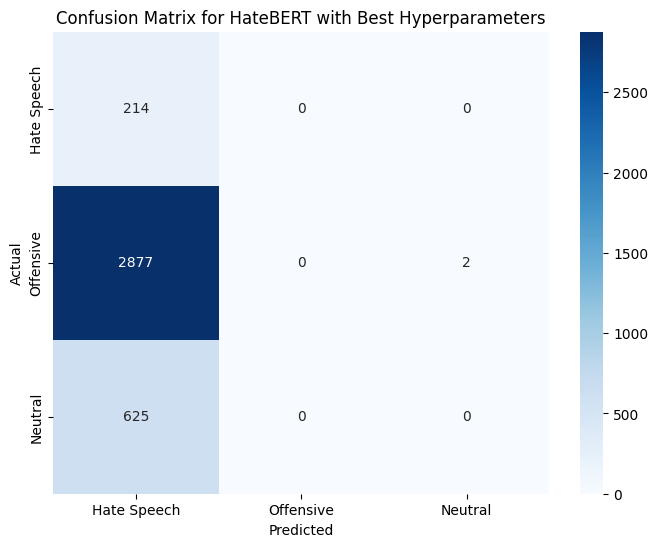

Classification Report for HateBERT with Best Hyperparameters:
              precision    recall  f1-score   support

 Hate Speech       0.06      1.00      0.11       214
   Offensive       0.00      0.00      0.00      2879
     Neutral       0.00      0.00      0.00       625

    accuracy                           0.06      3718
   macro avg       0.02      0.33      0.04      3718
weighted avg       0.00      0.06      0.01      3718



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [29]:
from transformers import TFBertForSequenceClassification
import tensorflow as tf
import keras_tuner as kt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

class_weights_dict = {0: 1.0, 1: 1.0, 2: 1.0}  # Set class weights

# Custom wrapper class for integrating Hugging Face model with KerasTuner
class KerasBertModel(tf.keras.Model):
    def __init__(self, model):
        super(KerasBertModel, self).__init__()
        self.bert = model

    def call(self, inputs):
        outputs = self.bert(inputs)  # Get the outputs tuple from the model
        logits = outputs.logits  # Extract the logits
        return logits  # Return logits for classification

# Function to build the model for KerasTuner
def build_hatebert_model(hp):
    # Load the pre-trained HateBERT model
    hatebert_model = TFBertForSequenceClassification.from_pretrained('GroNLP/hateBERT', num_labels=3)

    # Wrap the HateBERT model into a Keras model using the custom wrapper
    model = KerasBertModel(hatebert_model)

    # Tuneable hyperparameters
    learning_rate = hp.Float('learning_rate', min_value=1e-5, max_value=5e-5, sampling='LOG')
    dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)

    # Optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    # Compile the custom Keras model
    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )

    return model

# Initialize KerasTuner RandomSearch for hyperparameter tuning
tuner = kt.RandomSearch(
    build_hatebert_model,
    objective='val_accuracy',  # Optimizing validation accuracy
    max_trials=10,  # Number of different hyperparameter combinations to try
    executions_per_trial=1,  # Number of executions per trial
    directory='hatebert_tuning',
    project_name='hatebert_hyperparameter_tuning'
)

# Run the hyperparameter search
tuner.search(
    train_dataset,
    validation_data=val_dataset,
    epochs=3,  # You can adjust the number of epochs
)

# Get the best hyperparameters after the search
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameters found
print(f"Best learning rate: {best_hps.get('learning_rate')}")
print(f"Best dropout rate: {best_hps.get('dropout_rate')}")

# Rebuild the model with the best hyperparameters
best_model = tuner.hypermodel.build(best_hps)

# Train the best model with the optimal hyperparameters
history = best_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=5,  # Adjust epochs as needed
    class_weight=class_weights_dict  # Apply class weights here
)

# Evaluate the model on the test set
test_loss, test_accuracy = best_model.evaluate(test_dataset)
print(f"Test Accuracy with Best Hyperparameters: {test_accuracy:.4f}")

# Confusion Matrix and Classification Report (from previous code)
y_pred_logits = best_model.predict(test_dataset)
y_pred_classes = np.argmax(y_pred_logits, axis=1)

conf_matrix = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Hate Speech', 'Offensive', 'Neutral'], yticklabels=['Hate Speech', 'Offensive', 'Neutral'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix for HateBERT with Best Hyperparameters')
plt.show()

print("Classification Report for HateBERT with Best Hyperparameters:")
print(classification_report(y_test, y_pred_classes, target_names=['Hate Speech', 'Offensive', 'Neutral']))


### Analysis

Given the persistence of the issue, I have opted to manually finetune the hyperparameters as the class imbalance impacts the KerasTuner process.

In [51]:
import pandas as pd

# Loading the dataset directly from the GitHub URL
url = "https://raw.githubusercontent.com/t-davidson/hate-speech-and-offensive-language/master/data/labeled_data.csv"
df = pd.read_csv(url)

# Checking the first few rows to confirm loading
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [53]:
from transformers import BertTokenizer

# Re-load the original BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Function to encode the data using BERT tokenizer (no additional preprocessing)
def encode_data(texts, tokenizer, max_length):
    texts = [str(text) for text in texts]  # Ensure all are strings
    return tokenizer(
        texts,
        add_special_tokens=True,
        max_length=max_length,
        truncation=True,
        padding='max_length',
        return_tensors='tf'
    )

# Set maximum sequence length
max_length = 50

# Separate data into features (tweets) and labels (classes)
X = df['tweet']  # Ensure 'tweet' is the correct column in your dataset
y = df['class']  # Ensure 'class' is the correct column in your dataset

# Split the data back into train, validation, and test sets
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Encode the training, validation, and test data
train_encodings = encode_data(X_train, tokenizer, max_length)
val_encodings = encode_data(X_val, tokenizer, max_length)
test_encodings = encode_data(X_test, tokenizer, max_length)


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [54]:
import tensorflow as tf

# Ensure labels are in the correct format
y_train = tf.convert_to_tensor(y_train)
y_val = tf.convert_to_tensor(y_val)
y_test = tf.convert_to_tensor(y_test)


In [55]:
# Create datasets from clean data
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train
)).shuffle(10000).batch(32)

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    y_val
)).batch(32)

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    y_test
)).batch(32)


In [56]:
!pip install tensorflow
!pip install tf-keras
!pip install transformers
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification, create_optimizer
import numpy as np

# Load BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

# Function to encode the data using BERT tokenizer
def encode_data(texts, tokenizer, max_length):
    # Convert to list if it's a numpy array or pandas series
    if isinstance(texts, (np.ndarray, pd.Series)):
        texts = texts.tolist()
    # Ensure all elements are strings
    texts = [str(text) for text in texts]
    return tokenizer(
        texts,
        add_special_tokens=True,
        max_length=max_length,
        truncation=True,
        padding='max_length',
        return_tensors='tf'
    )

# Set maximum sequence length
max_length = 50

# Encode the training, validation, and test data
train_encodings = encode_data(X_train, tokenizer, max_length)
val_encodings = encode_data(X_val, tokenizer, max_length)
test_encodings = encode_data(X_test, tokenizer, max_length)

# Ensure labels are in the correct format
y_train = tf.convert_to_tensor(y_train)
y_val = tf.convert_to_tensor(y_val)
y_test = tf.convert_to_tensor(y_test)

# Create datasets
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train
)).shuffle(10000).batch(32)

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    y_val
)).batch(32)

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    y_test
)).batch(32)

# Create optimizer using create_optimizer from transformers
num_training_steps = len(train_dataset) * 3  # tried 1,3,5,10 epochs
optimizer, lr_schedule = create_optimizer(
    init_lr=2e-5, # tried 1e-5 to 5e-5
    num_warmup_steps=0,
    num_train_steps=num_training_steps
)


# Compile the BERT model
bert_model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# Train the BERT model
history = bert_model.fit(train_dataset, validation_data=val_dataset, epochs=3)

# Evaluate the BERT model on the test set
test_loss, test_accuracy = bert_model.evaluate(test_dataset)
print(f"Test Accuracy with BERT: {test_accuracy:.4f}")


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
543/543 [==============================] - 83s 89ms/step - loss: 0.3397 - accuracy: 0.8841 - val_loss: 0.2459 - val_accuracy: 0.9096
Epoch 2/3
543/543 [==============================] - 36s 66ms/step - loss: 0.2283 - accuracy: 0.9184 - val_loss: 0.2340 - val_accuracy: 0.9153
Epoch 3/3
117/117 [==============================] - 3s 25ms/step - loss: 0.2407 - accuracy: 0.9169
Test Accuracy with BERT: 0.9169


117/117 [==============================] - 6s 26ms/step


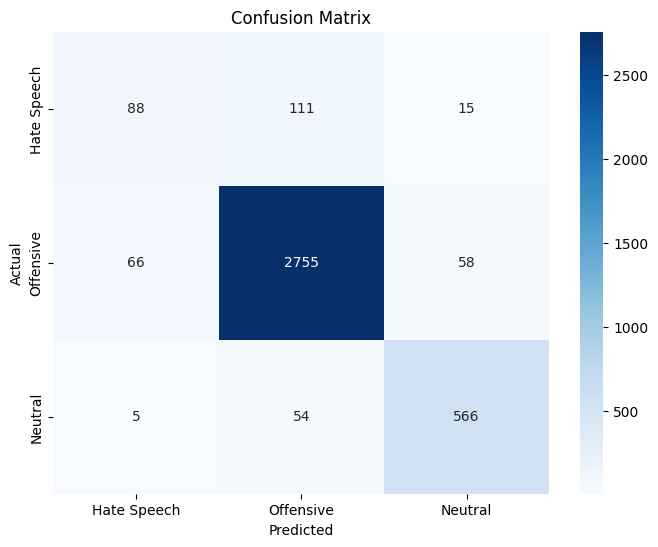

Classification Report:
              precision    recall  f1-score   support

 Hate Speech       0.55      0.41      0.47       214
   Offensive       0.94      0.96      0.95      2879
     Neutral       0.89      0.91      0.90       625

    accuracy                           0.92      3718
   macro avg       0.79      0.76      0.77      3718
weighted avg       0.91      0.92      0.91      3718



In [60]:
# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, labels):
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

# Generate predictions from the test set
y_pred_logits = bert_model.predict(test_dataset)
y_pred_classes = np.argmax(y_pred_logits.logits, axis=1)

# Confusion Matrix
plot_confusion_matrix(y_test, y_pred_classes, labels=['Hate Speech', 'Offensive', 'Neutral'])

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred_classes, target_names=['Hate Speech', 'Offensive', 'Neutral']))

### Analysis

Having tested the combinations and different variations for parameters, including by testing it against both the BERT and HateBERT, the best final result achieved was with the above parameters on the BERT model, with some preprocessing and finetuning but no data augmentation carried out.

The overall accuracy is the highest, at 92%
The F1 score for hate speech is 0.47, the best to date, albeit low still.
The offensive content has a very high F1 score, as does the neutral.

Overall this model performed the best having run trials on 24 different combinations.

## Integrating XAI into this model

There is value, in the context of a hate speech detection dataset, to understanding how and why the model makes the predcitions it does. For example, it could enable investigations into potential bias.

The approach to XAI that I will use is:
- First, to integrate attention visualisation to understand which part of the tweet influenced the model's decision
- Then to use LIME to provide local explanations for specific predictions

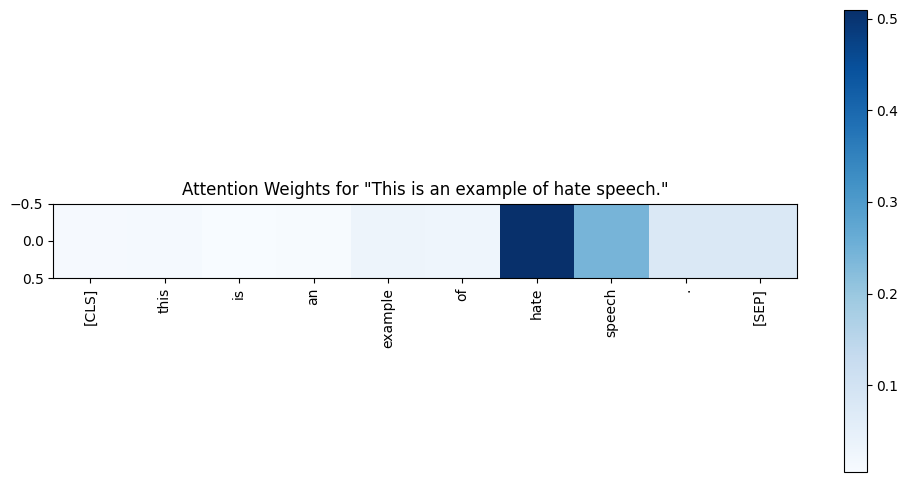

In [83]:
import matplotlib.pyplot as plt
import numpy as np

# Function to visualize attention weights for a given tweet
def visualize_attention_weights(input_text, model, tokenizer):
    # Tokenize the input text
    inputs = tokenizer(input_text, return_tensors='tf')

    # Get the attention weights from the model
    outputs = model(inputs, output_attentions=True)
    attentions = outputs.attentions[-1]  # Use the last layer's attention weights

    # Extract attention weights for the first token (CLS token)
    cls_attention = attentions[0][:, 0, :]

    # Reshape the attention weights to be 2D for visualization
    # Assuming cls_attention has shape (num_heads, sequence_length)
    # We need to reshape it to (num_heads, 1, sequence_length) for imshow
    cls_attention = cls_attention.numpy().reshape(cls_attention.shape[0], 1, -1)

    # Visualize the attention for each token
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
    plt.figure(figsize=(12, 6))
    # Display the first head's attention weights
    plt.imshow(cls_attention[0], cmap='Blues')
    plt.xticks(range(len(tokens)), tokens, rotation=90)
    plt.colorbar()
    plt.title(f'Attention Weights for "{input_text}"')
    plt.show()

# Example usage
input_text = "This is an example of hate speech."
visualize_attention_weights(input_text, bert_model, tokenizer)

In [64]:
!pip install lime


In [77]:
from lime import lime_text
from sklearn.pipeline import make_pipeline

# Wrap the tokenizer and model into a pipeline for LIME
class BERTWrapper:
    def __init__(self, model, tokenizer):
        self.model = model
        self.tokenizer = tokenizer

    def predict_proba(self, texts):
        # Tokenize input texts
        encodings = self.tokenizer(texts, return_tensors='tf', truncation=True, padding=True)
        # Predict using the model
        preds = self.model(encodings)
        # Convert logits to probabilities
        return tf.nn.softmax(preds.logits, axis=1).numpy()

# Initialize LIME explainer
bert_wrapper = BERTWrapper(bert_model, tokenizer)
explainer = lime_text.LimeTextExplainer(class_names=['Hate Speech', 'Offensive', 'Neutral'])

# Explain a single instance (tweet)
input_text = "This is an example of offensive speech."
exp = explainer.explain_instance(input_text, bert_wrapper.predict_proba, num_features=10)

# Visualize explanation with more categories (including Hate Speech)
exp.show_in_notebook(text=True)



## Overall - Results and Analysis

### Results table

In [89]:
import pandas as pd

# Create a list of dictionaries where each dictionary represents a model and its results
model_results = [
    {
        'Model': 'Baseline Model (LSTM)',
        'Accuracy': 0.8951,
        'Precision': 'macro: 0.73',
        'Recall': 'macro: 0.65',
        'F1-score': 'macro: 0.66'
    },
    {
        'Model': 'BERT (no fine-tuning)',
        'Accuracy': 0.1681,
        'Precision': 'macro: 0.10',
        'Recall': 'macro: 0.33',
        'F1-score': 'macro: 0.04'
    },
    {
        'Model': 'HateBERT (no augmentation)',
        'Accuracy': 0.89,
        'Precision': 'macro: 0.74',
        'Recall': 'macro: 0.72',
        'F1-score': 'macro: 0.72'
    },
    {
        'Model': 'HateBERT (with class weights)',
        'Accuracy': 0.89,
        'Precision': 'macro: 0.72',
        'Recall': 'macro: 0.71',
        'F1-score': 'macro: 0.71'
    },
    {
        'Model': 'HateBERT (with augmentation)',
        'Accuracy': 0.89,
        'Precision': 'macro: 0.73',
        'Recall': 'macro: 0.71',
        'F1-score': 'macro: 0.71'
    },
    {
        'Model': 'HateBERT (with best hyperparameters)',
        'Accuracy': 0.92,
        'Precision': 'macro: 0.79',
        'Recall': 'macro: 0.76',
        'F1-score': 'macro: 0.77'
    }
]

# Create a DataFrame from the list of dictionaries
results_df = pd.DataFrame(model_results)

# Display the DataFrame using Pandas
print(results_df)


                                  Model  Accuracy    Precision       Recall  \
0                 Baseline Model (LSTM)    0.8951  macro: 0.73  macro: 0.65   
1                 BERT (no fine-tuning)    0.1681  macro: 0.10  macro: 0.33   
2            HateBERT (no augmentation)    0.8900  macro: 0.74  macro: 0.72   
3         HateBERT (with class weights)    0.8900  macro: 0.72  macro: 0.71   
4          HateBERT (with augmentation)    0.8900  macro: 0.73  macro: 0.71   
5  HateBERT (with best hyperparameters)    0.9200  macro: 0.79  macro: 0.76   

      F1-score  
0  macro: 0.66  
1  macro: 0.04  
2  macro: 0.72  
3  macro: 0.71  
4  macro: 0.71  
5  macro: 0.77  


Strength: HateBERT with hyperparameter tuning achieved the highest accuracy (92%) and F1-score (0.77), showing strong overall performance and good handling of offensive and neutral classes.

Weakness: HateBERT, even with data augmentation and class weights, consistently struggled with detecting hate speech, showing low recall and F1-scores in that category. This shows the challenge posed by hate speech as commented in the analysis sections.

Improvement Area: BERT without fine-tuning performed poorly, highlighting the importance of domain-specific training and proper tuning for effective hate speech detection.

## Discussion and conclusion

Overall, the final results showed a very satisfactory improvement for such a notoriously difficult machine learning task, given how blurry hate speech definitions are and how much less data there is relatively, on it.

BERT vs. HateBERT
- HateBERT  outperformed standard BERT, demonstrating the importance of domain-specific models in hate speech detection, and both outperformed the baseline LSTM model.

Class Imbalance Challenge
- Despite using class weights and data augmentation, detecting hate speech remains a challenge, with low recall across multiple models, indicating the need for more sophisticated balancing techniques or additional hate speech data.

Impact of Hyperparameter Tuning
- Fine-tuning hyperparameters on HateBERT significantly improved performance, especially for offensive and neutral classes

Data Augmentation
- While data augmentation slightly boosted performance, it didn’t solve the issue of low hate speech detection accuracy, suggesting more advanced augmentation or alternative methods might be needed.

Explainability XAI
- LIME-based explanations provided valuable insights into model decisions, allowing deeper understanding of why certain predictions were made, which is critical for sensitive tasks like hate speech detection.

Future Work
- Future improvements could include exploring more advanced augmentation techniques, adversarial training, or ensembling multiple models to enhance hate speech classification.
- We could also look at developing the XAI side of the project such that one could investigate bias behind a model's classification of hate speech.